In [15]:
import pandas as pd
import tensorflow as tf
import transformers
from transformers import GPT2Tokenizer, TFGPT2LMHeadModel

c:\Users\hp\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
# !pip install transformers

In [17]:
# Load the GPT-2 model and tokenizer
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = TFGPT2LMHeadModel.from_pretrained(model_name)

c:\Users\hp\anaconda3\envs\tf\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\hp\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model che

In [18]:
# Read the text file into a DataFrame
data = pd.read_csv('./poem.txt', delimiter='\t')  # Adjust the delimiter as per your file format

# Print the DataFrame
data

,"Stay, I said"
0,to the cut flowers.
1,They bowed
2,their heads lower.
3,"Stay, I said to the spider,"
4,who fled.
...,...
2471,"gunwale, Islington and Isle of Wight, Housewife,"
2472,"verdict and indict. Finally, which rhymes with"
2473,"enough, Though, through, plough, or dough, or"
2474,cough? Hiccough has the sound of cup.


In [19]:
train_data = data.head(int(data.shape[0] * 0.8))
test_data = data.tail(int(data.shape[0] * 0.2))

In [20]:

# Tokenize and encode the dataset
input_ids = []
for poem in train_data:
    encoded_poem = tokenizer.encode(poem, add_special_tokens=True, truncation=True, max_length=512)
    input_ids.append(encoded_poem)

# Prepare the dataset for training
inputs = tf.data.Dataset.from_tensor_slices(input_ids)
inputs = inputs.map(lambda x: {"input_ids": x[:-1], "labels": x[1:]})
inputs = inputs.shuffle(1000).batch(batch_size=8)

# Fine-tune the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

epochs = 5
for epoch in range(epochs):
    for batch in inputs:
        with tf.GradientTape() as tape:
            inputs = batch["input_ids"]
            labels = batch["labels"]

            logits = model(inputs)[0]
            loss_value = loss_fn(labels, logits)

        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

# Generate poems based on user-defined topics
def generate_poem(topic, num_words):
    input_ids = tokenizer.encode(topic, return_tensors="tf")
    output = model.generate(input_ids=input_ids, max_length=num_words, num_return_sequences=1)
    generated_poem = tokenizer.decode(output[0], skip_special_tokens=True)
    return generated_poem

# Example usage
topic = "love"
num_words = 100
generated_poem = generate_poem(topic, num_words)
print("Generated Poem:")
print(generated_poem)


ResourceExhaustedError: OOM when allocating tensor with shape[50257,768] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:AddN]

In [21]:
data

,"Stay, I said"
0,to the cut flowers.
1,They bowed
2,their heads lower.
3,"Stay, I said to the spider,"
4,who fled.
...,...
2471,"gunwale, Islington and Isle of Wight, Housewife,"
2472,"verdict and indict. Finally, which rhymes with"
2473,"enough, Though, through, plough, or dough, or"
2474,cough? Hiccough has the sound of cup.


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras.utils as ku
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers


In [26]:
# !pip install wordcloud

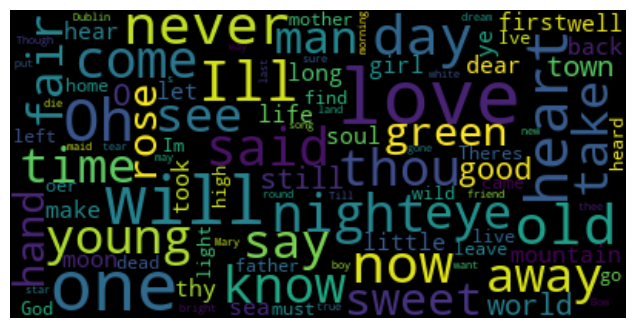

In [29]:
# Reading the text data file
data = open('./poem.txt', encoding="utf8").read()

# EDA: Generating WordCloud to visualize
# the text
wordcloud = WordCloud(max_font_size=50,
					max_words=100,
					background_color="black").generate(data)

# Plotting the WordCloud
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("WordCloud.png")
plt.show()


In [30]:
# Generating the corpus by
# splitting the text into lines
corpus = data.lower().split("\n")
print(corpus[:10])


['stay, i said', 'to the cut flowers.', 'they bowed', 'their heads lower.', 'stay, i said to the spider,', 'who fled.', 'stay, leaf.', 'it reddened,', 'embarrassed for me and itself.', 'stay, i said to my body.']


In [31]:
# Fitting the Tokenizer on the Corpus
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

# Vocabulary count of the corpus
total_words = len(tokenizer.word_index)

print("Total Words:", total_words)


Total Words: 3807


In [32]:
# Converting the text into embeddings
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]

	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences,
										maxlen=max_sequence_len,
										padding='pre'))
predictors, label = input_sequences[:, :-1], input_sequences[:, -1]
label = ku.to_categorical(label, num_classes=total_words+1)


In [33]:
# Building a Bi-Directional LSTM Model
model = Sequential()
model.add(Embedding(total_words+1, 100,
					input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words+1/2, activation='relu',
				kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words+1, activation='softmax'))
model.compile(loss='categorical_crossentropy',
			optimizer='adam', metrics=['accuracy'])
print(model.summary())


ResourceExhaustedError: failed to allocate memory [Op:Mul]

In [ ]:
history = model.fit(predictors, label, epochs=150, verbose=1)